In [21]:
import os
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from scipy import signal
from matplotlib import pyplot as plt
from dataloader import TestCase

601


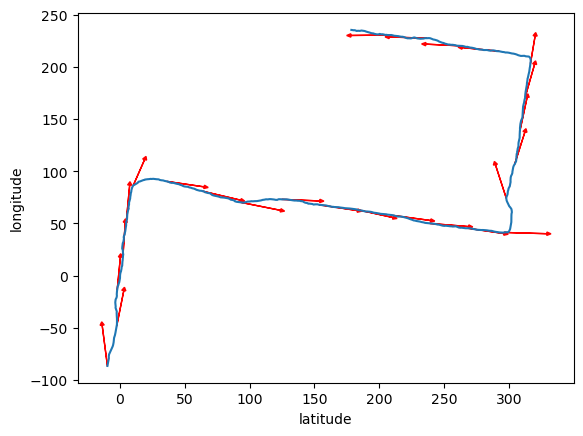

In [22]:
tc = TestCase('test_case0')
# tc = TestCase('../TestSet/test1')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning\Hand-Walk/Hand-Walk-02-005')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning/HandSwing-Walk/HandSwing-Walk-07-001')
# tc = tc.slice(10, 60)
print(len(tc.time_location))
tc.draw_route()

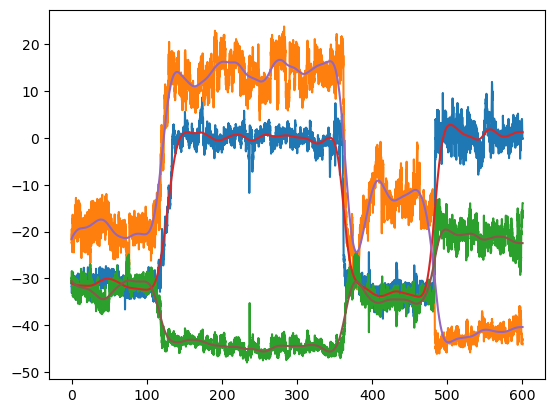

In [23]:
# 画出磁场方向
plt.plot(tc.time, tc.m_x)
plt.plot(tc.time, tc.m_y)
plt.plot(tc.time, tc.m_z)
# 低通滤波
b, a = signal.butter(2, 0.001, 'lowpass')
m_x = signal.filtfilt(b, a, tc.m_x)
m_y = signal.filtfilt(b, a, tc.m_y)
m_z = signal.filtfilt(b, a, tc.m_z)
m = np.array([m_x, m_y, m_z])
m = m.T
plt.plot(tc.time, m_x)
plt.plot(tc.time, m_y)
plt.plot(tc.time, m_z)
plt.show()

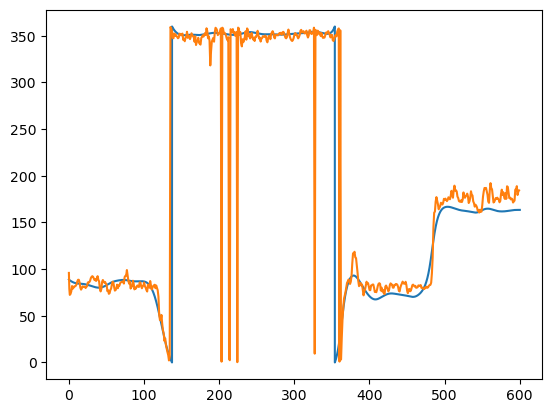

In [24]:
# 对 a 求平均得到重力加速度
g_x = np.mean(tc.a_x)
g_y = np.mean(tc.a_y)
g_z = np.mean(tc.a_z)
g = np.array([g_x, g_y, g_z])
# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 前 10% 个东向量平均值作为初始东向量
e0 = np.mean(e[:int(len(e) * 0.1)], axis=0)
# 前 10% 的 direction 的平均值作为初始 direction
direction0 = np.mean(tc.direction)
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0) / (np.linalg.norm(e, axis=1) * np.linalg.norm(e0))) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign(np.dot(np.cross(e, e0), g))
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
plt.plot(tc.time, direction)
plt.plot(tc.time_location, tc.direction_valid)
plt.show()